In [2]:
import pandas as pd
import numpy as np
import sklearn
from numpy import linalg as LA
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict


n=1000
q=1
SNR=8


def generate_data(n, p, SNR):
    
    #Generating coefficients beta
    beta=np.random.normal(0, 1, q)
    
    #Generating feature values: n*p matrix from N(0,1)
    X=np.random.normal(0, 1, (n,q))
    
    #Generating standard deviation, based on wanted SNR level gamma
    gamma=SNR
    sigma = np.sqrt(LA.norm(np.sinc(X).dot(beta))**2/(n-1))/gamma
    
    #Generating residuals
    epsilon=np.random.normal(0, sigma, n)
    
    #Generating responses
    #y=(X**2).dot(beta)+epsilon
    y=np.sinc(X).dot(beta)+epsilon
    
    return X,y,beta,epsilon,sigma,gamma

X,y,beta,epsilon,sigma,gamma = generate_data(n,q,SNR)
SNR_true = np.linalg.norm(np.sinc(X).dot(beta)) / np.linalg.norm(epsilon)
print(SNR_true)

7.877645960198289


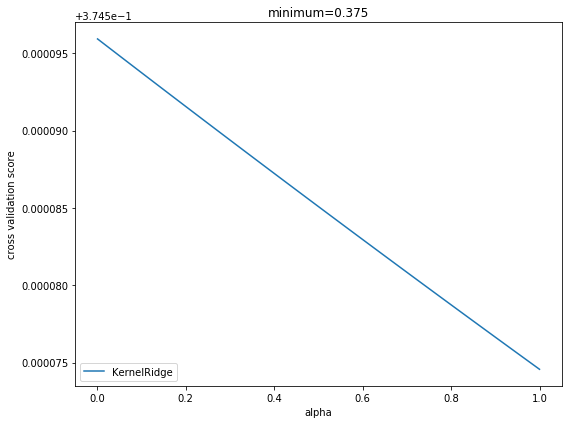

In [3]:
variables_to_scan = np.linspace(.001, 1, 100)

#Returning cross-validation error for a 5-fold split of training set
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

cv_KRR = [rmse_cv(make_pipeline(RobustScaler(),
                                
                                KernelRidge(alpha=var,
                                kernel='polynomial',
                                gamma=None, degree=2, coef0=7))).mean()          
                                              for var in variables_to_scan]

plt.figure(figsize=(8,6)) 
plt.plot(variables_to_scan, cv_KRR, label=KernelRidge.__name__)
plt.title('minimum=%1.3f' %min(cv_KRR))
plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

Best R2 score for the linear kernel is -0.726 with parameter {'alpha': 5}
Mean squared Error MSE linear: 0.713162179904647


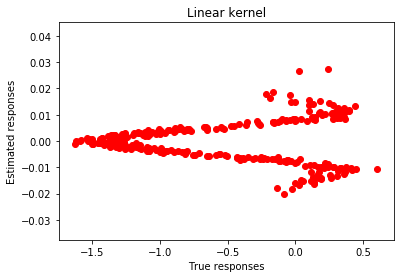

Best R2 score for the poly kernel is 0.37 with parameter {'alpha': 0.01, 'gamma': 0.01}
Mean squared Error MSE poly: 0.260162136254498


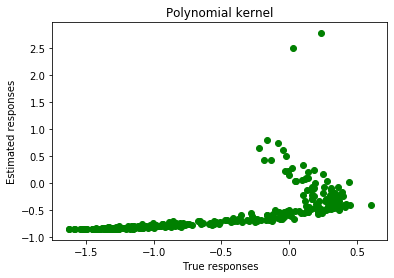

Best R2 score for the Gaussian kernel is 0.974 with parameter {'alpha': 0.1, 'gamma': 0.5}
Mean squared Error MSE gauss: 0.010833911362530296


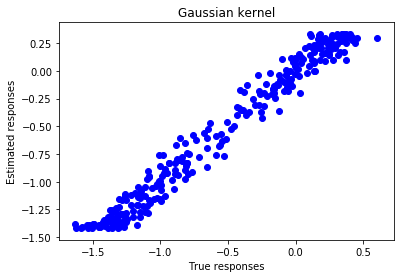

In [163]:
#different kernels 
def linear_kernel(x,x_prime):
    return (np.transpose(x).dot(x_prime))

def poly_kernel(x,x_prime,gamma,r,m):
    return (float((gamma*(np.transpose(x)*(x_prime))+r)**m))

def gaussian_kernel(x,x_prime,sigma):
    return (np.exp(-sum((x-x_prime)**2)/2*sigma**2))

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#linear
grid_linear=GridSearchCV(KernelRidge(kernel='linear'), param_grid={'alpha':[1e0,0.1,1e-2,1e-3,0.5,2,3,5]}, cv=5)
grid_linear.fit(X_train,Y_train)
grid_linear.best_score_
#Parameter setting that gave the best results on the hold out data.
grid_linear.best_params_
y_pred_lin=grid_linear.predict(X_test)
#R2 value of regression model defines how close the data is to the regression line 
#and the value should be closer to 1.
score=sklearn.metrics.r2_score(Y_test, y_pred_lin)
print('Best R2 score for the linear kernel is',round(score,3), 'with parameter', grid_linear.best_params_)

print('Mean squared Error MSE linear:', metrics.mean_squared_error(Y_test, y_pred_lin))# calculating MSE
plt.scatter(Y_test,y_pred_lin, color='red')
plt.xlabel('True responses')
plt.ylabel('Estimated responses')
plt.title('Linear kernel')
plt.show()
#print(score)

#polynomial
grid_polynomial= GridSearchCV(KernelRidge(kernel="polynomial", degree=3), cv=5, param_grid={"alpha":[1e0,0.1,1e-2,1e-3,0.5,2,3,5], "gamma":[0.001,0.0001,0.01,0.1,1,0.5,2,3]})
grid_polynomial.fit(X_train,Y_train)
grid_polynomial.best_params_
y_pred_poly=grid_polynomial.predict(X_test)
score_poly=sklearn.metrics.r2_score(Y_test, y_pred_poly)
print('Best R2 score for the poly kernel is',round(score_poly,3), 'with parameter', grid_polynomial.best_params_)
print('Mean squared Error MSE poly:', metrics.mean_squared_error(Y_test, y_pred_poly))# calculating MSE
plt.scatter(Y_test,y_pred_poly, color='green')
plt.xlabel('True responses')
plt.ylabel('Estimated responses')
plt.title('Polynomial kernel')
plt.show()
#print(score_poly)

#gaussian
grid_gaussian= GridSearchCV(KernelRidge(kernel="rbf"), cv=5, param_grid={"alpha":[1e0,0.1,1e-2,1e-3,0.5,2,3,5], "gamma":[0.001,0.0001,0.01,0.1,1,0.5,2,3,10]})
grid_gaussian.fit(X_train,Y_train)
grid_gaussian.best_params_
y_pred_gauss=grid_gaussian.predict(X_test)
score_gauss=sklearn.metrics.r2_score(Y_test, y_pred_gauss)
print('Best R2 score for the Gaussian kernel is',round(score_gauss,3), 'with parameter', grid_gaussian.best_params_)
print('Mean squared Error MSE gauss:', metrics.mean_squared_error(Y_test, y_pred_gauss))# calculating MSE
plt.scatter(Y_test,y_pred_gauss, color='blue')
plt.xlabel('True responses')
plt.ylabel('Estimated responses')
plt.title('Gaussian kernel')
plt.show()
#print(score_gauss)

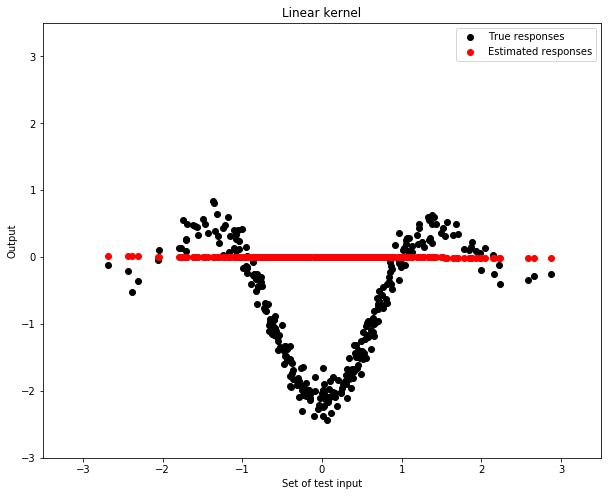

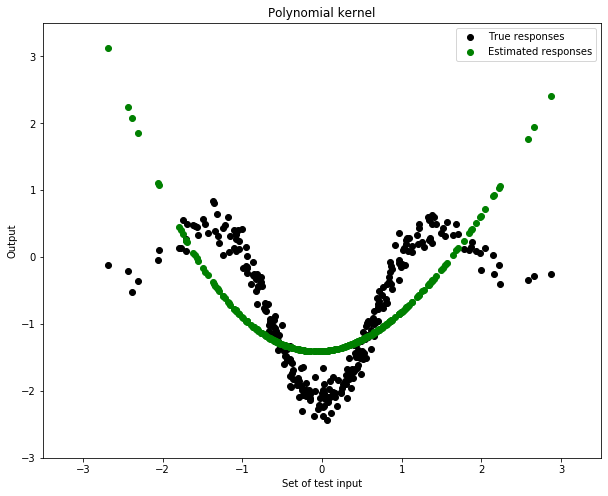

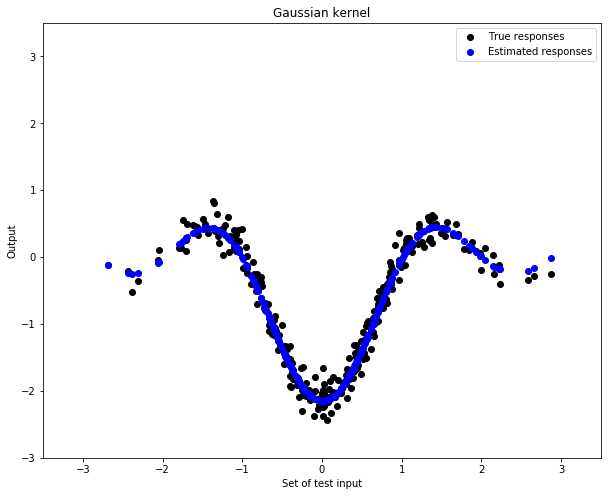

In [174]:
plt.figure(figsize=(10,8)) 
plt.scatter(X_test[:,0],Y_test, color='black', label='True responses')
plt.scatter(X_test[:,0],y_pred_lin, color='red', label='Estimated responses')
plt.xlabel('Set of test input')
plt.ylabel('Output')
plt.title('Linear kernel')
plt.xlim(-3.5, 3.5)
plt.ylim(-3, 3.5)
plt.legend()
plt.show()


plt.figure(figsize=(10,8)) 
plt.scatter(X_test[:,0],Y_test, color='black', label='True responses')
plt.scatter(X_test[:,0],y_pred_poly, color='green', label='Estimated responses')
plt.xlabel('Set of test input')
plt.ylabel('Output')
plt.title('Polynomial kernel')
plt.xlim(-3.5, 3.5)
plt.ylim(-3, 3.5)
plt.legend()
plt.show()

plt.figure(figsize=(10,8)) 
plt.scatter(X_test[:,0],Y_test, color='black', label='True responses')
plt.scatter(X_test[:,0],y_pred_gauss, color='blue', label='Estimated responses')
plt.xlabel('Set of test input')
plt.ylabel('Output')
plt.title('Gaussian kernel')
plt.xlim(-3.5, 3.5)
plt.ylim(-3, 3.5)
plt.legend()
plt.show()

In [1]:
max_iter = 10

MSE_linear=[]
MSE_polynomial=[]
MSE_gaussian=[]

for i in range(max_iter):

    X,y,beta,epsilon,sigma,gamma = generate_data(n,q,SNR)
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #linear
    grid_linear=GridSearchCV(KernelRidge(kernel='linear'), param_grid={'alpha':[1e0,0.1,1e-2,1e-3,0.5,2,3,5]}, cv=5)
    grid_linear.fit(X_train,Y_train)
    grid_linear.best_score_
    grid_linear.best_params_
    y_pred_lin=grid_linear.predict(X_test)
    score=sklearn.metrics.r2_score(Y_test, y_pred_lin)
    MSE_linear.append(metrics.mean_squared_error(Y_test, y_pred_lin))# calculating MSE


    #polynomial
    grid_polynomial= GridSearchCV(KernelRidge(kernel="polynomial", degree=3), cv=5, param_grid={"alpha":[1e0,0.1,1e-2,1e-3,0.5,2,3,5], "gamma":[0.001,0.0001,0.01,0.1,1,0.5,2,3]})
    grid_polynomial.fit(X_train,Y_train)
    grid_polynomial.best_params_
    y_pred_poly=grid_polynomial.predict(X_test)
    score_poly=sklearn.metrics.r2_score(Y_test, y_pred_poly)
    MSE_polynomial.append(metrics.mean_squared_error(Y_test, y_pred_poly))# calculating MSE


    #gaussian
    grid_gaussian= GridSearchCV(KernelRidge(kernel="rbf"), cv=5, param_grid={"alpha":[1e0,0.1,1e-2,1e-3,0.5,2,3,5], "gamma":[0.001,0.0001,0.01,0.1,1,0.5,2,3,10]})
    grid_gaussian.fit(X_train,Y_train)
    grid_gaussian.best_params_
    y_pred_gauss=grid_gaussian.predict(X_test)
    score_gauss=sklearn.metrics.r2_score(Y_test, y_pred_gauss)
    MSE_gaussian.append(metrics.mean_squared_error(Y_test, y_pred_gauss)) # calculating MSE
    
print('Averaged MSE for linear kernel is:', np.mean(MSE_linear))
print('Averaged MSE for polynomial kernel is:',np.mean(MSE_polynomial))
print('Averaged MSE for gaussian kernel is:',np.mean(MSE_gaussian))

NameError: name 'generate_data' is not defined